# Code Overview

This script sets up the environment and imports the necessary libraries for building and training a Convolutional Neural Network (CNN) using TensorFlow and Keras.

#### Environment Setup
- Sets the TensorFlow logging level to minimize log output.
- Ignores Python warnings to keep the output clean.


In [44]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.simplefilter("ignore")
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator                             # type: ignore
from tensorflow.keras.models import Sequential                                                  # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense   # type: ignore
from tensorflow.keras.optimizers import Adam                                                    # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint                                          # type: ignore
from tensorflow.keras import backend as K                                                       # type: ignore

## Image Dimensions and Data Directories

This section of the script defines the image dimensions and the directories for training data. It also sets the validation split ratio for the dataset.

In [45]:
img_width, img_height = 150, 150
train_data_dir = 'ml_data/train'
validation_split = 0.2  

## Training Parameters and Input Shape

This section of the script sets the training parameters, including the number of epochs and batch size, and defines the input shape of the images based on the image data format.

In [46]:
epochs = 30
batch_size = 16
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Data Loading Function

This function `load_data` prepares the training and validation datasets using data augmentation techniques. It leverages the `ImageDataGenerator` class from Keras to create augmented image data generators for both training and validation sets.


In [47]:
def load_data(train_data_dir, img_width, img_height, batch_size, validation_split):
    datagen = ImageDataGenerator(
        rotation_range=30,
        rescale=1. / 255,
        shear_range=0.2,
        brightness_range=(0.2, 0.5),
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=validation_split                # Validation split
    )

    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'                                # Training data
    )

    validation_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'                              # Validation data
    )

    return train_generator, validation_generator

## Data Preparation Function

This function `prepare_data` organizes images into category-specific directories, making it easier to use them for training and validation.


In [48]:
def prepare_data(train_data_dir, img_extensions=['.jpg', '.jpeg', '.png']):
    categories = ['apple', 'banana', 'orange', 'mixed']
    for cat in categories:
        os.makedirs(os.path.join(train_data_dir, cat), exist_ok=True)

    for img_file in os.listdir(train_data_dir):
        if any(img_file.lower().endswith(ext) for ext in img_extensions):
            for cat in categories:
                if cat in img_file.lower():
                    shutil.move(os.path.join(train_data_dir, img_file),
                                os.path.join(train_data_dir, cat, img_file))
                    break

## Model Building Function

This function `build_model` constructs a Convolutional Neural Network (CNN) using the Keras Sequential API. The model consists of multiple convolutional blocks followed by fully connected layers, and is designed for multi-class classification.


In [49]:
def build_model(input_shape):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second convolutional block
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third convolutional block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4))                    # 4 output classes
    model.add(Activation('softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    model.summary()

    return model

## Model Training Function

This function `train_model` trains a given model using the provided data generators for training and validation. It also saves the best model based on validation accuracy using the `ModelCheckpoint` callback.

In [50]:
# Model training function
def train_model(model, train_generator, validation_generator, epochs):
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint]
    )

    return model, history


## Model Evaluation Function

This function `evaluate_model` evaluates a trained model using a validation generator and prints the validation accuracy.

In [51]:
def evaluate_model(model, validation_generator):
    accuracy = model.evaluate(validation_generator)

    print('Validation accuracy:', accuracy)

## Model Saving Function

This function `save_model` saves a trained model to a specified file.

In [52]:
def save_model(model, filename):
    model.save(filename)
    print(f"Model saved to {filename}")

## Test Data Loading Function

This function `load_test_data` prepares the test dataset for evaluation. It uses an `ImageDataGenerator` to load and preprocess the images from the test data directory.

In [53]:
def load_test_data(test_data_dir, img_width, img_height, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)

    test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',                               # Ensure categorical mode
        shuffle=False                                           # Keep data order to match labels and predictions
    )

    return test_generator

## Main Program

The main program starts from this point below. 

## Data Preparation and Model Building

1. **Preparing Data**: Organizes images into category-specific directories for efficient data processing.
2. **Loading Data**: Loads training and validation datasets with augmentation for model training.
3. **Building Model**: Constructs a CNN model for image classification based on specified input shape.


In [54]:
prepare_data(train_data_dir)  # Preprocess data
train_generator, validation_generator = load_data(train_data_dir, img_width, img_height, batch_size, validation_split)
model = build_model(input_shape)



Found 192 images belonging to 4 classes.


Found 46 images belonging to 4 classes.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         2,052 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,523,236 (82.10 MB)

 Trainable params: 21,523,236 (82.10 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training and Evaluation

1. **Training Model**: Trains the model using the training and validation generators for a specified number of epochs, saving the training history.
2. **Evaluating Model**: Evaluates the trained model on the validation dataset to assess its performance.
3. **Saving Model**: Saves the trained model as 'fruit_classifier.keras' for future use.


In [55]:
model, history = train_model(model, train_generator, validation_generator, epochs)
evaluate_model(model, validation_generator)
save_model(model, 'fruit_classifier.keras')  # Save model


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.2433 - loss: 1.4650
Epoch 1: val_accuracy improved from -inf to 0.32609, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 805ms/step - accuracy: 0.2450 - loss: 1.4604 - val_accuracy: 0.3261 - val_loss: 1.3268
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.3114 - loss: 1.3265
Epoch 2: val_accuracy did not improve from 0.32609
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 663ms/step - accuracy: 0.3107 - loss: 1.3286 - val_accuracy: 0.3043 - val_loss: 1.2765
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.3218 - loss: 1.3133
Epoch 3: val_accuracy did not improve from 0.32609
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 682ms/step - accuracy: 0.3199 - loss: 1.3136 - val_accuracy: 0.2826 - val_loss: 1.2936
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.3546 - loss: 1.3086
Epoch 4: val_accuracy improved from 0.32609 to 0.39130, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━

## Creating Test Dataset DataFrame

Creates a DataFrame `df_test` containing information about the test dataset images, including filenames and corresponding classes (apple, banana, mixed, orange). The output includes a DataFrame `df_test` showing the filenames and predicted classes for the test images, as well as the test loss and accuracy of the model.


In [56]:
# Define image information
apple_images = [f"apple_{i}.jpg" for i in range(77, 96)]
banana_images = [f"banana_{i}.jpg" for i in range(77, 95)]
mixed_images = [f"mixed_{i}.jpg" for i in range(21, 26)]
orange_images = [f"orange_{i}.jpg" for i in range(77, 96)]

# Create DataFrame
df_test = pd.DataFrame({
       'filename': apple_images + banana_images + mixed_images + orange_images,
       'class': ['apple'] * len(apple_images) + ['banana'] * len(banana_images) + ['mixed'] * len(mixed_images) + ['orange'] * len(orange_images)
})

# Display DataFrame
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
print(df_test)

         filename   class
0    apple_77.jpg   apple
1    apple_78.jpg   apple
2    apple_79.jpg   apple
3    apple_80.jpg   apple
4    apple_81.jpg   apple
5    apple_82.jpg   apple
6    apple_83.jpg   apple
7    apple_84.jpg   apple
8    apple_85.jpg   apple
9    apple_86.jpg   apple
10   apple_87.jpg   apple
11   apple_88.jpg   apple
12   apple_89.jpg   apple
13   apple_90.jpg   apple
14   apple_91.jpg   apple
15   apple_92.jpg   apple
16   apple_93.jpg   apple
17   apple_94.jpg   apple
18   apple_95.jpg   apple
19  banana_77.jpg  banana
20  banana_78.jpg  banana
21  banana_79.jpg  banana
22  banana_80.jpg  banana
23  banana_81.jpg  banana
24  banana_82.jpg  banana
25  banana_83.jpg  banana
26  banana_84.jpg  banana
27  banana_85.jpg  banana
28  banana_86.jpg  banana
29  banana_87.jpg  banana
30  banana_88.jpg  banana
31  banana_89.jpg  banana
32  banana_90.jpg  banana
33  banana_91.jpg  banana
34  banana_92.jpg  banana
35  banana_93.jpg  banana
36  banana_94.jpg  banana
37   mixed_2

## Evaluating Model on Test Dataset

1. **Initializing Data Generator**: Initializes an ImageDataGenerator `datagen_test` for test data with pixel rescaling.
2. **Creating Test Data Generator**: Creates a test data generator `test_generator` using the DataFrame `df_test` and the test data directory.
3. **Evaluating Model**: Evaluates the trained model on the test dataset using the `evaluate` method, calculating the loss and accuracy.
4. **Displaying Results**: Prints the test loss and accuracy.


In [57]:
# Initialize ImageDataGenerator
datagen_test = ImageDataGenerator(rescale=1. / 255)

# Create test data generator
test_data_dir = 'ml_data/test'
test_generator = datagen_test.flow_from_dataframe(
       dataframe=df_test,
       directory=test_data_dir,
       x_col='filename',
       y_col='class',
       target_size=(img_width, img_height),
       batch_size=batch_size,
       class_mode='categorical',
       shuffle=False
)

loss, accuracy = model.evaluate(test_generator)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Found 60 validated image filenames belonging to 4 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.9442 - loss: 0.5388
Test loss: 0.6164161562919617
Test accuracy: 0.9333333373069763


## Plotting Training and Validation Accuracy

Plots the training and validation accuracy over epochs to visualize the model's performance.


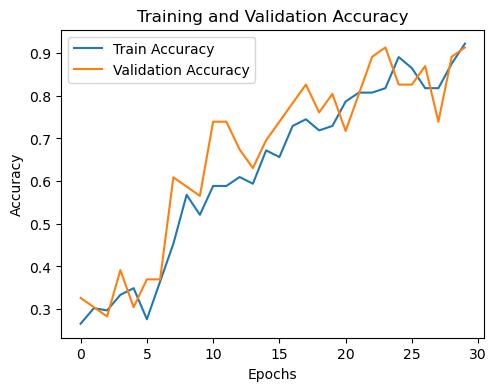

In [58]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Plotting Training and Validation Loss

Plots the training and validation loss over epochs to visualize the model's performance.


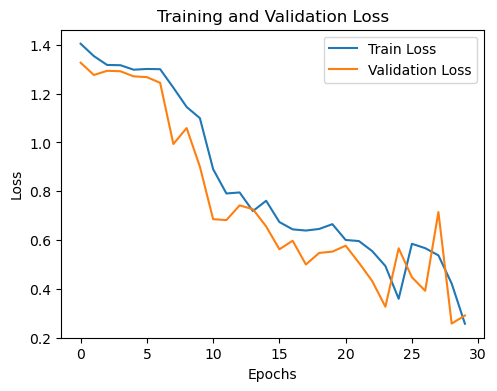

In [59]:
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()